# Time dependence and PT-TEMPO

A quick introduction on how to use the OQuPy package to compute the dynamics of a time dependent quantum system and how to employ the process tensor TEMPO method. We illustrate this by applying TEMPO and PT-TEMPO to a quantum dot driven by a time dependent laser pulse.

- [launch binder](https://mybinder.org/v2/gh/tempoCollaboration/OQuPy/HEAD?labpath=tutorials%2Fpt_tempo.ipynb) (runs in browser),
- [download the jupyter file](https://raw.githubusercontent.com/tempoCollaboration/OQuPy/main/tutorials/pt_tempo.ipynb), or
- read through the text below and code along.

**Contents:**

* Example - Quantum dot driven by a laser pulse
    * 1. Hamiltonian for driven quantum dot with bosonic environment
    * 2. Laser pulse / time dependent system
    * 3. Create time dependent system object
    * 4. TEMPO computation
    * 5. Using PT-TEMPO to explore many different laser pulses

First, let's import OQuPy and some other packages we are going to use

In [1]:
import sys
sys.path.insert(0,'..')

import oqupy
import numpy as np
import matplotlib.pyplot as plt

and check what version of tempo we are using.

In [2]:
oqupy.__version__

'0.4.0'

Let's also import some shorthands for the spin Pauli operators and density matrices.

In [3]:
sigma_x = oqupy.operators.sigma("x")
sigma_y = oqupy.operators.sigma("y")
sigma_z = oqupy.operators.sigma("z")
up_density_matrix = oqupy.operators.spin_dm("z+")
down_density_matrix = oqupy.operators.spin_dm("z-")
mixed_density_matrix = oqupy.operators.spin_dm("mixed")

-------------------------------------------------
## Example - Quantum Dot driven by a laser pulse

As a first example let's try to reconstruct one of the lines in figure 3c of [Fux2021] ([Phys. Rev. Lett. 126, 200401 (2021)](https://link.aps.org/doi/10.1103/PhysRevLett.126.200401) / [arXiv:2101.03071](https://arxiv.org/abs/2101.03071)). In this example we compute the time evolution of a quantum dot which is driven with a $\pi/2$ laser pulse and is strongly coupled to an ohmic bath (spin-boson model). 

### 1. Hamiltonian for driven quantum dot with bosonic environment
We consider a time dependent system Hamiltonian
$$ H_{S}(t) = \frac{\Delta(t)}{2} \hat{\sigma}_z + \frac{\Omega(t)}{2} \hat{\sigma}_x \mathrm{,}$$
which may describe transitions between the ground and exciton state driven by a resonant laser pulse (in the rotating frame). Here, $\Delta(t)$ is the detuning of the laser with respect to the transition and $\Omega(t)$ is proportional to the electric field of the laser.
We further include a bosonic environment
$$ H_{B} = \sum_k \omega_k \hat{b}^\dagger_k \hat{b}_k  \mathrm{,}$$
and an interaction Hamiltonian
$$ H_{I} =  \frac{1}{2} \hat{\sigma}_z \sum_k \left( g_k \hat{b}^\dagger_k + g^*_k \hat{b}_k \right) \mathrm{,}$$
where $\hat{\sigma}_i$ are the Pauli operators, and the $g_k$ and $\omega_k$ are such that the spectral density $J(\omega)$ is
$$ J(\omega) = \sum_k |g_k|^2 \delta(\omega - \omega_k) = 2 \, \alpha \, \frac{\omega^3}{\omega_\mathrm{cutoff}^2} \, \exp\left(-\frac{\omega^2}{\omega_\mathrm{cutoff}^2}\right) \mathrm{.} $$
Also, let's assume the initial density matrix of the quantum dot is the ground state
$$ \rho_0 = \begin{pmatrix} 0 & 0 \\ 0 & 1 \end{pmatrix} $$
and the bath is initially at temperature $T$.

We express all frequencies, temperatures and times in units of 1/ps and ps respectively.

* $\omega_c = 3.04 \frac{1}{\mathrm{ps}}$
* $\alpha = 0.126$
* $T = 1 K = 0.1309 \frac{1}{\mathrm{ps}\,\mathrm{k}_B}$

In [4]:
omega_cutoff = 3.04 
alpha = 0.126
temperature = 0.1309
initial_state=down_density_matrix

### 2. Laser pulse / time dependent system

We choose a gaussian laser pulse shape with an adjustable pulse area and pulse width $\tau$.

In [5]:
def gaussian_shape(t, area = 1.0, tau = 1.0, t_0 = 0.0):
    return area/(tau*np.sqrt(np.pi)) * np.exp(-(t-t_0)**2/(tau**2))

Choosing a pulse area of $\pi/2$, a pulse width of 245 fs and no detuning, we can check the shape of the laser pulse.

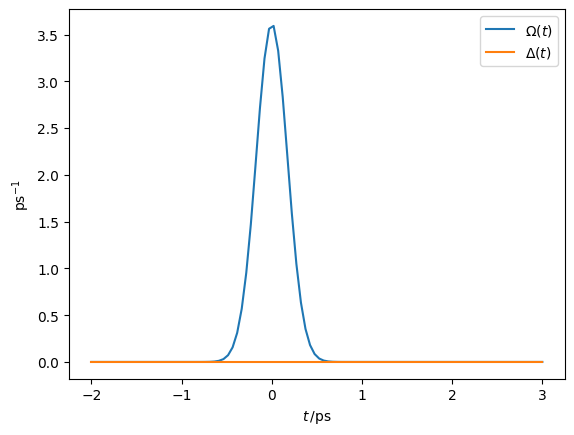

In [6]:
detuning = lambda t: 0.0 * t

t = np.linspace(-2,3,100)
Omega_t = gaussian_shape(t, area = np.pi/2.0, tau = 0.245)
Delta_t = detuning(t)

plt.plot(t, Omega_t,label=r"$\Omega(t)$")
plt.plot(t, Delta_t,label=r"$\Delta(t)$")
plt.xlabel(r"$t\,/\mathrm{ps}$")
plt.ylabel(r"$\mathrm{ps}^{-1}$")
plt.legend()

### 3. Create time dependent system object

In [7]:
def hamiltonian_t(t):
    return detuning(t)/2.0 * sigma_z \
           + gaussian_shape(t, area = np.pi/2.0, tau = 0.245)/2.0 * sigma_x

system = oqupy.TimeDependentSystem(hamiltonian_t)
correlations = oqupy.PowerLawSD(alpha=alpha,
                                zeta=3,
                                cutoff=omega_cutoff,
                                cutoff_type='gaussian',
                                temperature=temperature)
bath = oqupy.Bath(sigma_z/2.0, correlations)

### 4. TEMPO computation

With all physical objects defined, we are now ready to compute the dynamics of the quantum dot using TEMPO (using quite rough convergence parameters):

In [8]:
tempo_parameters = oqupy.TempoParameters(dt=0.1, tcut=2.0, epsrel=10**(-4))

tempo_sys = oqupy.Tempo(system=system,
                        bath=bath,
                        initial_state=initial_state,
                        start_time=-2.0,
                        parameters=tempo_parameters)
dynamics = tempo_sys.compute(end_time=3.0)

--> TEMPO computation:
100.0%   50 of   50 [########################################] 00:00:00
Elapsed time: 0.7s


and extract the expectation values $\langle\sigma_{xy}\rangle = \sqrt{\langle\sigma_x\rangle^2 + \langle\sigma_y\rangle^2}$ for plotting:

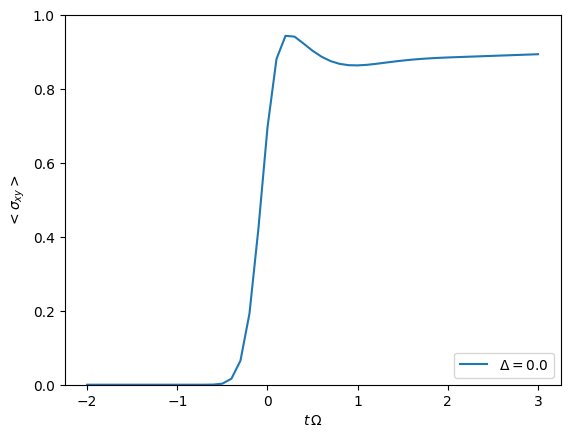

In [9]:
t, s_x = dynamics.expectations(sigma_x, real=True)
t, s_y = dynamics.expectations(sigma_y, real=True)
s_xy = np.sqrt(s_x**2 + s_y**2)
plt.plot(t, s_xy, label=r'$\Delta = 0.0$')
plt.xlabel(r'$t\,\Omega$')
plt.ylabel(r'$<\sigma_{xy}>$')
plt.ylim((0.0,1.0))
plt.legend(loc=4)

### 5. Using PT-TEMPO to explore many different laser pulses
If we want to do the same computation for a set of different laser pulses (and thus different time dependent system Hamiltonians), we could repeate the above procedure. However, for a large number of different system Hamiltonians this is impractical. In such cases one may instead use the process tensor approach (PT-TEMPO) wherein the bath influence tensors are computed separately from the rest of the network. This produces an object known as the process tensor which may then be used with many different system Hamiltonians at relatively little cost.

In [10]:
tempo_parameters = oqupy.TempoParameters(dt=0.1, tcut=2.0, epsrel=10**(-4))

process_tensor = oqupy.pt_tempo_compute(bath=bath,
                                        start_time=-2.0,
                                        end_time=3.0,
                                        parameters=tempo_parameters)

--> PT-TEMPO computation:
100.0%   50 of   50 [########################################] 00:00:00
Elapsed time: 0.3s


Given we want to calculate $\langle\sigma_{xy}\rangle(t)$ for 5 different laser pulse detunings, we define a seperate system object for each laser pulse:

In [11]:
deltas = [-10.0, -5.0, 0.0, 5.0, 10.0]
systems = []
for delta in deltas:
    # NOTE: omitting "delta=delta" in the parameter definition below
    #       would lead to all systems having the same detuning.
    #       This is a common python pitfall. Check out 
    #       https://docs.python-guide.org/writing/gotchas/#late-binding-closures
    #       for more information on this.
    def hamiltonian_t(t, delta=delta): 
        return delta/2.0 * sigma_z \
            + gaussian_shape(t, area = np.pi/2.0, tau = 0.245)/2.0 * sigma_x 
    system = oqupy.TimeDependentSystem(hamiltonian_t)
    systems.append(system)

We can then use the process tensor to compute the dynamics for each laser pulse

In [12]:
s_xy_list = []
t_list = []
for system in systems:
    dynamics = oqupy.compute_dynamics(
        process_tensor=process_tensor,
        system=system,
        initial_state=initial_state,
        start_time=-2.0,
        progress_type="silent")
    t, s_x = dynamics.expectations(sigma_x, real=True)
    _, s_y = dynamics.expectations(sigma_y, real=True)
    s_xy = np.sqrt(s_x**2 + s_y**2)
    s_xy_list.append(s_xy)
    t_list.append(t)
    print(".", end="", flush=True)
print(" done.", flush=True)

..... done.


and plot $\langle\sigma_{xy}\rangle(t)$ for each:

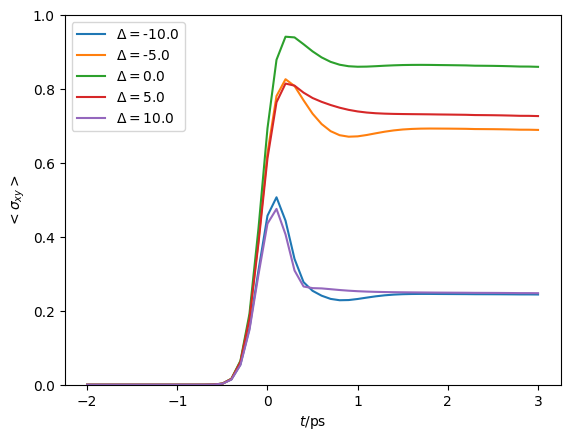

In [13]:
for t, s_xy, delta in zip(t_list, s_xy_list, deltas):
    plt.plot(t, s_xy, label=r"$\Delta = $"+f"{delta:0.1f}")
    plt.xlabel(r'$t/$ps')
    plt.ylabel(r'$<\sigma_{xy}>$')
plt.ylim((0.0,1.0))
plt.legend()